In [1]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import cv2
import re
import sys

In [2]:
# !pip install -i https://pypi.tuna.tsinghua.edu.cn/simple keras

0


C:\Users\22335\AppData\Local\Temp\ipykernel_30472\978011071.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)


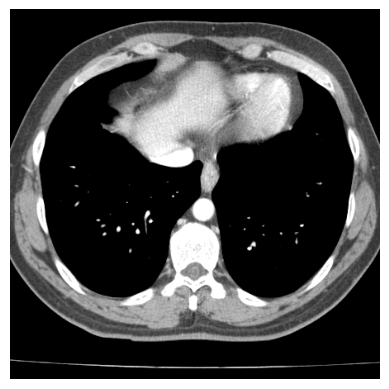

In [4]:
mask = cv2.imread('../Train_Sets/CT/1/Ground/liver_GT_007.png', cv2.IMREAD_GRAYSCALE)
print(mask.min())
image_slice = pydicom.dcmread('../Train_Sets/CT/1/DICOM_anon/i0007,0000b.dcm') 
images = get_single_pixels_hu(image_slice)
# images = transform_ctdata(images,500,150)
# images /= 255.
images[images > 200] = 200
images[images < -200] = -200

images = images.astype(np.float32)
images = images / 200
images = images[32:480,32:480]



ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)

ctImageArray[:, :,0] = images[:, :]

plt.imshow(ctImageArray,cmap='gray')
plt.axis('off')



imagepath = 'demo.npy'


np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')


(-0.5, 511.5, 511.5, -0.5)

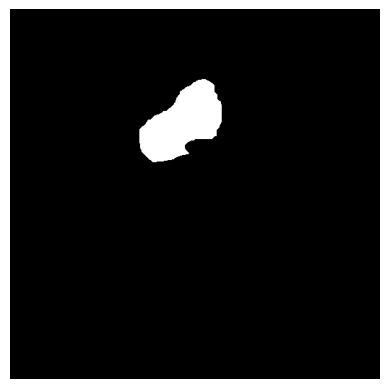

In [20]:

plt.imshow(mask,cmap='gray')
plt.axis('off')

In [2]:
def get_single_pixels_hu(image_slice):
    image = np.stack(image_slice.pixel_array)
    image = image.astype(np.float32)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = image_slice.RescaleIntercept
    slope = image_slice.RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.float32)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.float32)

def get_pixels_hu(scans):
    #type(scans[0].pixel_array)
    #Out[15]: numpy.ndarray
    #scans[0].pixel_array.shape
    #Out[16]: (512, 512)
    # image.shape: (129,512,512)
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans.RescaleIntercept
    slope = scans.RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def transform_ctdata(image, windowWidth, windowCenter, normal=False):
        """
        注意，这个函数的self.image一定得是float类型的，否则就无效！
        return: trucated image according to window center and window width
        """
        minWindow = float(windowCenter) - 0.5*float(windowWidth)
        newimg = (image - minWindow) / float(windowWidth)
        newimg[newimg < 0] = 0
        newimg[newimg > 1] = 1
        if not normal:
            newimg = (newimg * 255).astype('float32')
        return newimg

def getRangImageDepth(image):
    """
    args:
    image ndarray of shape (depth, height, weight)
    """
    # 得到轴向上出现过目标（label>=1)的切片
    z = np.any(image, axis=(1,2)) # z.shape:(depth,)
    startposition,endposition = np.where(z)[0][[0,-1]]
    return startposition, endposition

def getRangImageDepth(image):
    """
    args:
    image ndarray of shape (depth, height, weight)
    """
    firstflag = True
    startposition = 0
    endposition = 0
    for z in range(image.shape[0]):
        notzeroflag = np.max(image[z])
        if notzeroflag and firstflag:
            startposition = z
            firstflag = False
        if notzeroflag:
            endposition = z
    return startposition, endposition

def clahe_equalized(imgs,start,end):
   assert (len(imgs.shape)==3)  #3D arrays
   #create a CLAHE object (Arguments are optional).
   clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
   imgs_equalized = np.empty(imgs.shape)
   for i in range(start, end+1):
       imgs_equalized[i,:,:] = clahe.apply(np.array(imgs[i,:,:], dtype = np.uint8))
   return imgs_equalized

def get_highest_acc():
    pattern = 'model.(?P<epoch>\d+)-(?P<val_acc>[0-9]*\.?[0-9]*).hdf5'
    p = re.compile(pattern)
    acces = [float(p.match(f).groups()[1]) for f in os.listdir('models/') if p.match(f)]
    if len(acces) == 0:
        return sys.float_info.min
    else:
        return np.max(acces)

In [3]:
def plot(originImage, originMask, tumor_mask):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    ax[0].imshow(originImage,cmap='gray')
    ax[1].imshow(originMask,cmap='gray')
    ax[2].imshow(tumor_mask,cmap='gray')
    figure.tight_layout()
    figure.show()

In [5]:
outputImg_path = "data/chaos/Image"
outputMask_path = "data/chaos/Mask"

if not os.path.exists(outputImg_path):
    os.makedirs(outputImg_path)
if not os.path.exists(outputMask_path):
    os.makedirs(outputMask_path)



for i in range(1, 21):
    # file_path = '../3Dircadb1/3Dircadb1.%d/PATIENT_DICOM/' % i
    try:
        file_path = '../Train_Sets/CT/%d/DICOM_anon/' % i
        masks_path = '../Train_Sets/CT/%d/Ground/' % i
        print(file_path)
        nums = len(os.listdir(file_path))
        images_ = os.listdir(file_path)
        masks = os.listdir(masks_path)
        # print(images[1].split(',')[0][-3:])
        images_.sort(key=lambda x:int(x.split(',')[0][-3:]))
        masks.sort(key=lambda x:int((x.split('_')[-1]).split('.')[0]))
    except Exception as e:
        print(e)
        continue
    for j in range(0, nums):
        liver_path = masks_path + masks[j]
        data_path = file_path  + images_[j]
        # print(liver_path, data_path)
        try:

            image_slice = pydicom.dcmread(data_path) 

            
            livers = cv2.imread(liver_path, cv2.IMREAD_GRAYSCALE)


            if livers.max() > 0:
                print(livers.max())
                images = get_single_pixels_hu(image_slice)
                # images = transform_ctdata(images,500,150)
                # images /= 255.
                images[images > 200] = 200
                images[images < -200] = -200

                images = images.astype(np.float32)
                images = images / 200
                images = images[32:480,32:480]

                livers = livers[32:480,32:480]
                livers[livers == livers.max()] = 1



                ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)

                ctImageArray[:, :,0] = images[:, :]



                imagepath = outputImg_path + "/" + str(i) + "_" + str(j) + ".npy"
                maskpath = outputMask_path + "/" + str(i) + "_" + str(j) + ".npy"

                np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')
                np.save(maskpath, livers)  # (448，448) dtype('uint8') 值为0 1 2 
                
        except FileNotFoundError as e:
                print(e)
print('finish!')
    




../Train_Sets/CT/1/DICOM_anon/
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


C:\Users\22335\AppData\Local\Temp\ipykernel_30472\1088073531.py:55: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)


255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
../Train_Sets/CT/2/DICOM_anon/
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
../Train_Sets/CT/3/DICOM_anon/
[WinError 3] 系统找不到指定的路径。: '../Train_Sets/CT/3/DICOM_anon/'
../Train_Sets/CT/4/DICOM_anon/
[WinError 3] 系统找不到指定的路径。: '../Train_Sets/CT/4/DICOM_anon/'
../Train_Sets/CT/5/DICOM_anon/
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
25

In [6]:
outputImg_path = "data/chaos/Image"
outputMask_path = "data/chaos/Mask"

if not os.path.exists(outputImg_path):
    os.makedirs(outputImg_path)
if not os.path.exists(outputMask_path):
    os.makedirs(outputMask_path)



for i in range(21, 31):
    # file_path = '../3Dircadb1/3Dircadb1.%d/PATIENT_DICOM/' % i
    try:
        file_path = '../Train_Sets/CT/%d/DICOM_anon/' % i
        masks_path = '../Train_Sets/CT/%d/Ground/' % i
        print(file_path)
        nums = len(os.listdir(file_path))
        images_ = os.listdir(file_path)
        masks = os.listdir(masks_path)
        # print(images[1].split(',')[0][-3:])
        images_.sort(key=lambda x:int((x.split('-')[-1]).split('.')[0][-3:]))
        masks.sort(key=lambda x:int((x.split('_')[-1]).split('.')[0]))
    except Exception as e:
        print(e)
        continue
    for j in range(0, nums):
        liver_path = masks_path + masks[j]
        data_path = file_path  + images_[j]

        # print(liver_path, data_path)
        try:

            image_slice = pydicom.dcmread(data_path) 

            
            livers = cv2.imread(liver_path, cv2.IMREAD_GRAYSCALE)


            if livers.max() > 0:
                print(livers.max())
                images = get_single_pixels_hu(image_slice)
                # images = transform_ctdata(images,500,150)
                # images /= 255.
                images[images > 200] = 200
                images[images < -200] = -200

                images = images.astype(np.float32)
                images = images / 200
                images = images[32:480,32:480]

                livers = livers[32:480,32:480]
                livers[livers == livers.max()] = 1



                ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)

                ctImageArray[:, :,0] = images[:, :]



                imagepath = outputImg_path + "/" + str(i) + "_" + str(j) + ".npy"
                maskpath = outputMask_path + "/" + str(i) + "_" + str(j) + ".npy"

                np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')
                np.save(maskpath, livers)  # (448，448) dtype('uint8') 值为0 1 2 
                
        except FileNotFoundError as e:
                print(e)
print('finish!')
    




../Train_Sets/CT/21/DICOM_anon/
255
255
255
255
255
255
255
255
255


C:\Users\22335\AppData\Local\Temp\ipykernel_30472\139910614.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)


255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
../Train_Sets/CT/22/DICOM_anon/
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


/home/jouiry/anaconda3/envs/medseg/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


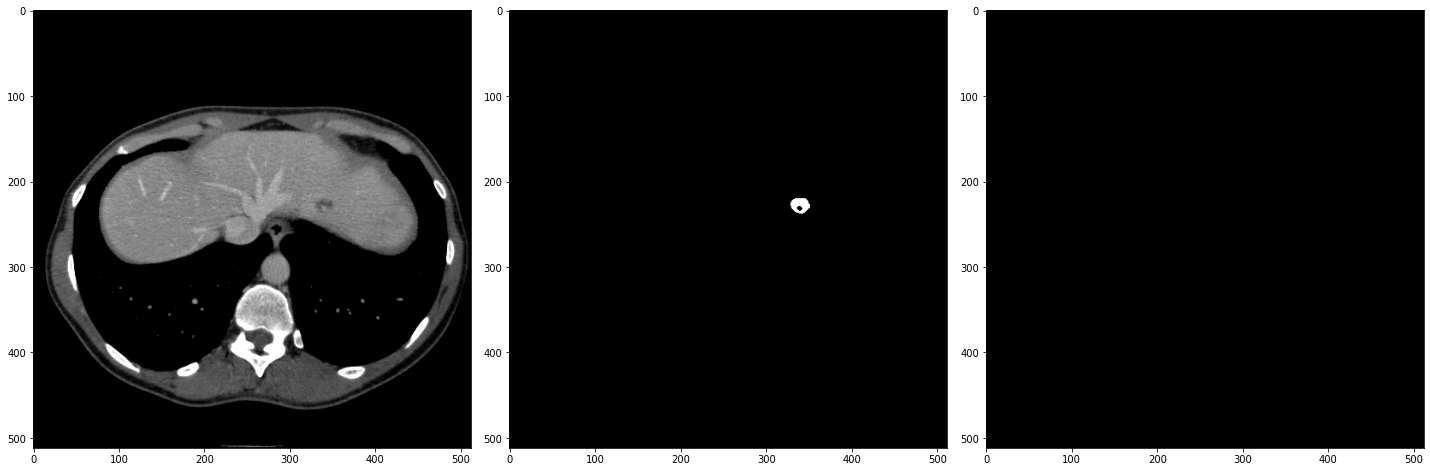

In [102]:

i, j = 8, 110
liver_path = '../3Dircadb1/3Dircadb1.%d/MASKS_DICOM/livertumor/image_%d' % (i, j)
tumor_path = '../3Dircadb1/3Dircadb1.%d/MASKS_DICOM/livertumor02/image_%d' % (i, j)
data_path = '../3Dircadb1/3Dircadb1.%d/PATIENT_DICOM/image_%d' % (i, j)

liver_slice = pydicom.dcmread(liver_path)
tumor1 = np.stack([liver_slice.pixel_array])

image_slice = pydicom.dcmread(data_path) 

tumor = pydicom.dcmread(tumor_path)
tumor2 = np.stack(tumor.pixel_array)



images = get_single_pixels_hu(image_slice)
images = transform_ctdata(images,500,150)
images /= 255.


plot(images, np.squeeze(tumor1), tumor2)

In [4]:
# for liver
outputImg_path = "data/3Diradb/liver/Image"
outputMask_path = "data/3Diradb/liver/Mask"

if not os.path.exists(outputImg_path):
    os.makedirs(outputImg_path)
if not os.path.exists(outputMask_path):
    os.makedirs(outputMask_path)
for i in range(1, 21):
    file_path = '../3Dircadb1/3Dircadb1.%d/PATIENT_DICOM/' % i
    nums = len(os.listdir(file_path))
    for j in range(0, nums):
        liver_path = '../3Dircadb1/3Dircadb1.%d/MASKS_DICOM/liver/image_%d' % (i, j)
        data_path = '../3Dircadb1/3Dircadb1.%d/PATIENT_DICOM/image_%d' % (i, j)
        try:
            
            liver_slice = pydicom.dcmread(liver_path)
            livers = np.stack([liver_slice.pixel_array])

            image_slice = pydicom.dcmread(data_path) 
            
            


            if livers.max() > 0:
                print(livers.max())
                images = get_single_pixels_hu(image_slice)
                # images = transform_ctdata(images,500,150)
                # images /= 255.
                images[images > 200] = 200
                images[images < -200] = -200

                images = images.astype(np.float32)
                images = images / 200
                images = images[32:480,32:480]
                livers = np.squeeze(livers)
                livers = livers[32:480,32:480]
                livers[livers == livers.max()] = 1


                ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)

                ctImageArray[:, :,0] = images[:, :]



                imagepath = outputImg_path + "/" + str(i) + "_" + str(j) + ".npy"
                maskpath = outputMask_path + "/" + str(i) + "_" + str(j) + ".npy"

                np.save(imagepath, ctImageArray)  # (448，448,3) np.float dtype('float64')
                np.save(maskpath, livers)  # (448，448) dtype('uint8') 值为0 1 2 
                
        except FileNotFoundError as e:
                print(e)
print('finish!')
    




255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255


/tmp/ipykernel_580996/1405367745.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctImageArray = np.zeros((images.shape[0], images.shape[1], 1), np.float)


255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
